<a href="https://colab.research.google.com/github/sanjivyash/ML-Codes/blob/master/GAN_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import os
from tqdm.notebook import tqdm
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv

In [0]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [3]:
if(torch.cuda.is_available()):
    device = torch.device('cuda:0')
    print('Running on the GPU')
else:
    device = torch.device('cpu')
    print('Running on the CPU')

Running on the GPU


In [0]:
import torchvision 
from torchvision.datasets import MNIST
from torchvision import transforms as T
from torch.utils.data.dataloader import DataLoader

In [5]:
dataset = MNIST(root = 'data/',
                train = True,
                download = True,
                transform = T.Compose([T.ToTensor(),
                                       T.Normalize((0.5,), (0.5,))]))

print(len(dataset))

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw




Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw
Processing...
Done!
60000


/pytorch/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


In [6]:
dataset

Dataset MNIST
    Number of datapoints: 60000
    Root location: data/
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5,), std=(0.5,))
           )

In [0]:
def display_image(img, plot=True):
    '''
    Takes in a normalised tensor, denormalises it 
    and then displays it
    ''' 
    image = img.view(28, 28).detach().clone().cpu().numpy()
    image = (image + 1) / 2
    plt.imshow(image, cmap='gray')
    plt.show()

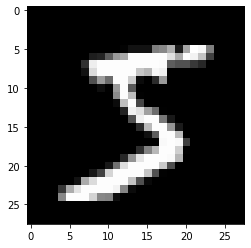

5

In [8]:
img, label = dataset[0]
display_image(img.view(28,28))
label

In [0]:
batch_size = 128

real_data = DataLoader(dataset,
                       batch_size = batch_size,
                       shuffle = True)

In [10]:
D = nn.Sequential(
    nn.Linear(784, 256),
    nn.LeakyReLU(0.2),
    
    nn.Linear(256, 64),
    nn.LeakyReLU(0.2),

    nn.Linear(64, 1),
    nn.Sigmoid()
)

print(sum(p.numel() for p in D.parameters() if p.requires_grad))
D.to(device)

217473


Sequential(
  (0): Linear(in_features=784, out_features=256, bias=True)
  (1): LeakyReLU(negative_slope=0.2)
  (2): Linear(in_features=256, out_features=64, bias=True)
  (3): LeakyReLU(negative_slope=0.2)
  (4): Linear(in_features=64, out_features=1, bias=True)
  (5): Sigmoid()
)

In [11]:
latent_size = 128

G = nn.Sequential(
    nn.Linear(latent_size, 256),
    nn.ReLU(),

    nn.Linear(256, 256),
    nn.ReLU(),

    nn.Linear(256, 28 * 28),
    nn.Tanh()
)

print(sum(p.numel() for p in G.parameters() if p.requires_grad))
G.to(device)

300304


Sequential(
  (0): Linear(in_features=128, out_features=256, bias=True)
  (1): ReLU()
  (2): Linear(in_features=256, out_features=256, bias=True)
  (3): ReLU()
  (4): Linear(in_features=256, out_features=784, bias=True)
  (5): Tanh()
)

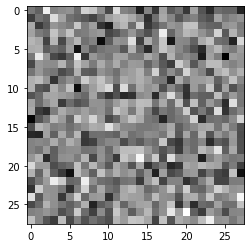

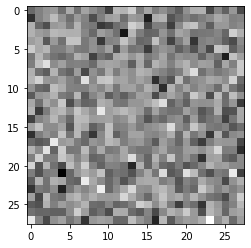

In [12]:
images = G(torch.randn(2, latent_size).to(device))
for img in images:
    display_image(img)

In [0]:
criterion = nn.BCELoss()
D_optim = optim.Adam(D.parameters(), lr=0.0005)
G_optim = optim.Adam(G.parameters(), lr=0.0005)

In [0]:
def reset_grad():
    D.zero_grad()
    G.zero_grad()

In [0]:
def train_discriminator(real_images):
    # Create the labels
    real_labels = torch.ones(batch_size, 1).to(device)
    fake_labels = torch.zeros(batch_size, 1).to(device)

    # Loss for real images
    real_scores = D(real_images)
    D_loss_real = criterion(real_scores, real_labels)

    # Loss for fake images
    r = torch.randn(batch_size, latent_size).to(device)
    fake_images = G(r)
    fake_scores = D(fake_images)
    D_loss_fake = criterion(fake_scores, fake_labels)

    # Total Loss
    D_loss = D_loss_real + D_loss_fake

    # Optimise
    reset_grad()
    D_loss.backward()
    D_optim.step()

    return D_loss, real_scores, fake_scores

In [0]:
def train_generator():
    # Generate fake images
    r = torch.randn(batch_size, latent_size).to(device)
    fake_images = G(r)
    labels = torch.ones(batch_size, 1).to(device)
    G_loss = criterion(D(fake_images), labels)

    # Optimise
    reset_grad()
    G_loss.backward()
    G_optim.step()

    return G_loss, fake_images

In [0]:
sample_dir = '/content/samples'

if not os.path.exists(sample_dir):
    os.makedirs(sample_dir)

In [0]:
def convert_images(img):
    out = (img + 1)/2
    return out.clamp(0, 1)

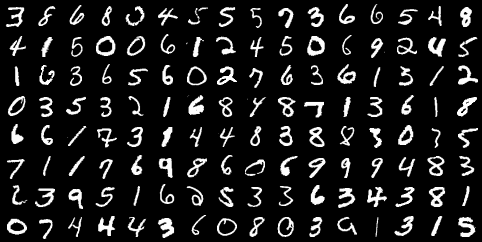

In [19]:
from IPython.display import Image
from torchvision.utils import save_image

# Save the real images
for images, _ in real_data:
    images = images.reshape(-1, 1, 28, 28)
    save_image(convert_images(images), os.path.join(sample_dir, 'real_images.png'), nrow=16)
    break

Image(os.path.join(sample_dir, 'real_images.png'))

Saving fake_images-0000.png


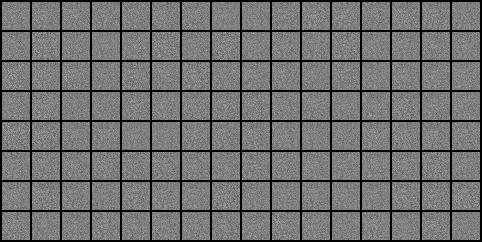

In [20]:
sample_vectors = torch.randn(batch_size, latent_size).to(device)

def save_fake_images(index):
    fake_images = G(sample_vectors)
    fake_images = fake_images.reshape(fake_images.size(0), 1, 28, 28)
    fake_fname = f'fake_images-{index:0=4d}.png'
    print('Saving', fake_fname)
    save_image(convert_images(fake_images), os.path.join(sample_dir, fake_fname), nrow=16)
    
# Before training
save_fake_images(0)
Image(os.path.join(sample_dir, 'fake_images-0000.png'))

In [21]:
num_epochs = 300
total_step = len(real_data)
D_losses, G_losses, real_scores, fake_scores = [], [], [], []

for epoch in tqdm(range(num_epochs)):
    for i, (images, _) in enumerate(real_data):
        # Load a batch & transform to vectors
        images = images.reshape(batch_size, -1).to(device)
        
        # Train the discriminator and generator
        try:
            D_loss, real_score, fake_score = train_discriminator(images)
            G_loss, fake_images = train_generator()
            
            # Inspect the losses
            if (i+1) % 200 == 0:
                D_losses.append(D_loss.item())
                G_losses.append(G_loss.item())
                real_scores.append(real_score.mean().item())
                fake_scores.append(fake_score.mean().item())
                print(f'Epoch [{epoch}/{num_epochs}], Step [{i+1}/{total_step}], D_loss: {D_loss.item():.4f}, G_loss: {G_loss.item():.4f}, D(x): {real_score.mean().item():.2f}, D(G(z)): {fake_score.mean().item():.2f}') 
        
        except:
            pass

    # Sample and save images
    save_fake_images(epoch+1)

Epoch [0/300], Step [200/469], D_loss: 0.7147, G_loss: 1.2645, D(x): 0.89, D(G(z)): 0.43
Epoch [0/300], Step [400/469], D_loss: 0.2014, G_loss: 5.2774, D(x): 0.94, D(G(z)): 0.10
Saving fake_images-0001.png
Epoch [1/300], Step [200/469], D_loss: 0.9713, G_loss: 6.0943, D(x): 0.85, D(G(z)): 0.31
Epoch [1/300], Step [400/469], D_loss: 0.3527, G_loss: 3.3620, D(x): 0.91, D(G(z)): 0.20
Saving fake_images-0002.png
Epoch [2/300], Step [200/469], D_loss: 0.6687, G_loss: 2.3459, D(x): 0.79, D(G(z)): 0.27
Epoch [2/300], Step [400/469], D_loss: 0.3325, G_loss: 2.4171, D(x): 0.87, D(G(z)): 0.16
Saving fake_images-0003.png
Epoch [3/300], Step [200/469], D_loss: 0.6433, G_loss: 1.9555, D(x): 0.79, D(G(z)): 0.25
Epoch [3/300], Step [400/469], D_loss: 1.0985, G_loss: 1.1961, D(x): 0.61, D(G(z)): 0.38
Saving fake_images-0004.png
Epoch [4/300], Step [200/469], D_loss: 1.1779, G_loss: 1.3517, D(x): 0.64, D(G(z)): 0.40
Epoch [4/300], Step [400/469], D_loss: 1.3360, G_loss: 1.7623, D(x): 0.60, D(G(z)): 0.4

In [0]:
torch.save(G.state_dict(), 'G.pty')
torch.save(D.state_dict(), 'D.pty')

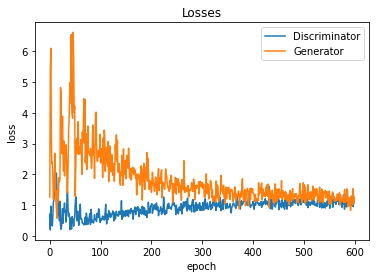

In [23]:
plt.plot(D_losses, '-')
plt.plot(G_losses, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');

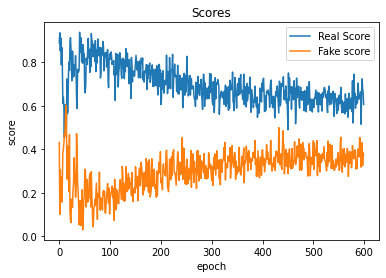

In [24]:
plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real Score', 'Fake score'])
plt.title('Scores');

In [0]:
fourcc = cv2.VideoWriter_fourcc(*'XVID')
# ouqt = cv2.VideoWriter('output.avi', fourcc, 20, (640, 480))
out = cv2.VideoWriter('/content/gans_training.avi', fourcc, 10, (400, 400))
paths = []

for img in os.listdir(sample_dir):
    path = os.path.join(sample_dir, img)
    paths.append(path)

paths.sort()

for path in paths:
    if paths[-1] == path:
        break
    frame = cv.imread(path)
    out.write(frame)

out.release()